### Quick and Dirty One Hour Model !

In [1]:
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [2]:
train_clean = pd.read_csv('./datasets/train_data_cleaned_v1')

In [3]:
train_clean.head()

,Unnamed: 0,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,60,RL,0.0,13517,Pave,no,IR1,Lvl,AllPub,...,0,0,0,no,0,0,3,2010,WD,130500
1,1,60,RL,43.0,11492,Pave,no,IR1,Lvl,AllPub,...,0,0,0,no,0,0,4,2009,WD,220000
2,2,20,RL,68.0,7922,Pave,no,Reg,Lvl,AllPub,...,0,0,0,no,0,0,1,2010,WD,109000
3,3,60,RL,73.0,9802,Pave,no,Reg,Lvl,AllPub,...,0,0,0,no,0,0,4,2010,WD,174000
4,4,50,RL,82.0,14235,Pave,no,IR1,Lvl,AllPub,...,0,0,0,no,0,0,3,2010,WD,138500


In [4]:
train_clean.isna().sum().sum()

6

In [5]:
train_clean.dropna(inplace=True)

In [6]:
train_clean['totrms_abvgrd'].value_counts()

6     596
7     475
5     407
8     228
4     145
9      98
10     49
11     22
3      12
12     12
2       1
13      1
14      1
Name: totrms_abvgrd, dtype: int64

In [7]:
#assumed important features just from general knowledge and previous experience as a home owner and when looking at real estate
#naive model may not be the exact right term, but I am making no assumption here that this is a good or bad model
train_clean[['exter_cond', 'exter_qual', 'bsmt_cond', 'bsmt_qual', 'kitchen_qual', 'garage_cond', 'garage_qual', 'pool_qc', 'overall_cond',
            'overall_qual', 'utilities', 'gr_liv_area', 'total_bsmt_sf', 'full_bath', 'half_bath', 'totrms_abvgrd']].head()

,exter_cond,exter_qual,bsmt_cond,bsmt_qual,kitchen_qual,garage_cond,garage_qual,pool_qc,overall_cond,overall_qual,utilities,gr_liv_area,total_bsmt_sf,full_bath,half_bath,totrms_abvgrd
0,TA,Gd,TA,TA,Gd,TA,TA,0,8,6,AllPub,1479,725.0,2,1,6
1,TA,Gd,TA,Gd,Gd,TA,TA,0,5,7,AllPub,2122,913.0,2,1,8
2,Gd,TA,TA,TA,Gd,TA,TA,0,7,5,AllPub,1057,1057.0,1,0,5
3,TA,TA,TA,Gd,TA,TA,TA,0,5,5,AllPub,1444,384.0,2,1,7
4,TA,TA,Gd,Fa,TA,TA,TA,0,8,6,AllPub,1445,676.0,2,0,6


In [8]:
#creating a total squarefoot column
train_clean['total_sf'] = train_clean['total_bsmt_sf'] + train_clean['gr_liv_area']

In [9]:
train_clean[['total_bsmt_sf', 'gr_liv_area', 'total_sf']].sort_values(by= 'total_sf', ascending=False).head()

,total_bsmt_sf,gr_liv_area,total_sf
328,3200.0,3228,6428.0
1226,2846.0,2696,5542.0
1895,1836.0,3672,5508.0
1163,3094.0,2402,5496.0
1388,2033.0,3238,5271.0


In [10]:
train_clean['bedroom_abvgr']

0       3
1       4
2       3
3       3
4       3
       ..
2044    3
2045    1
2046    3
2047    3
2048    3
Name: bedroom_abvgr, Length: 2047, dtype: int64

In [55]:
features = ['exter_cond', 'exter_qual', 'bsmt_cond', 'bsmt_qual', 'kitchen_qual', 'garage_cond', 'garage_qual', 'overall_cond', 'bedroom_abvgr',
            'overall_qual', 'utilities', 'gr_liv_area', 'total_bsmt_sf', 'full_bath', 'half_bath', 'totrms_abvgrd', 'total_sf', 'saleprice']

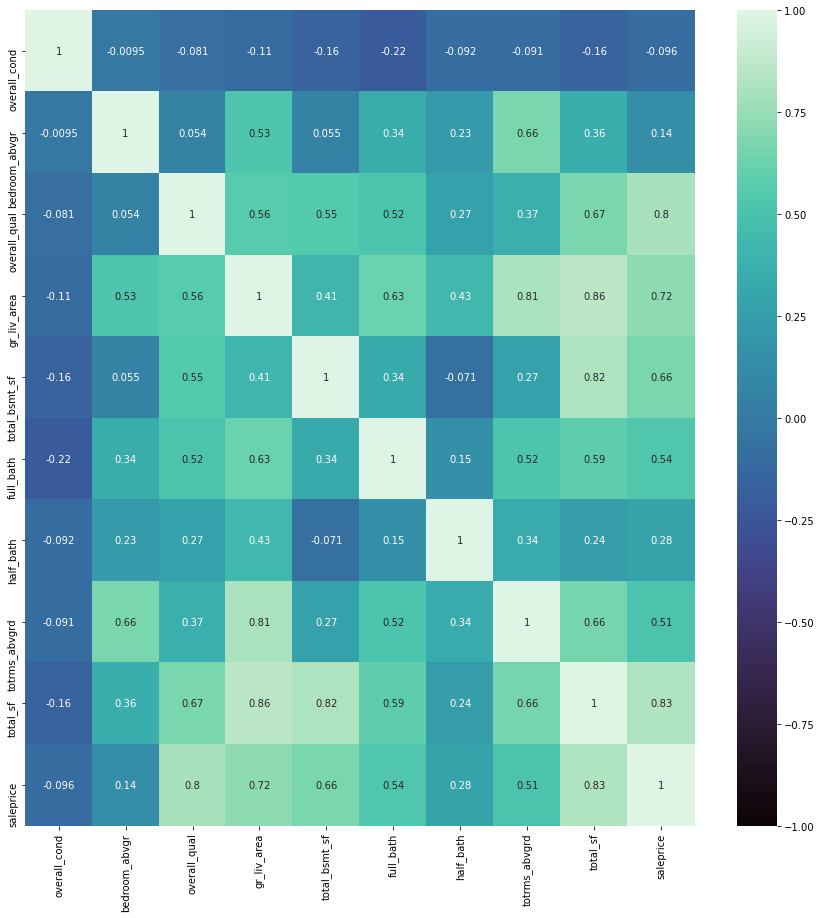

In [56]:
plt.figure(figsize= (15,15))

sns.heatmap(train_clean[features].corr(), 
            annot= True,
           vmax=1,
           vmin=-1,
           cmap='mako');

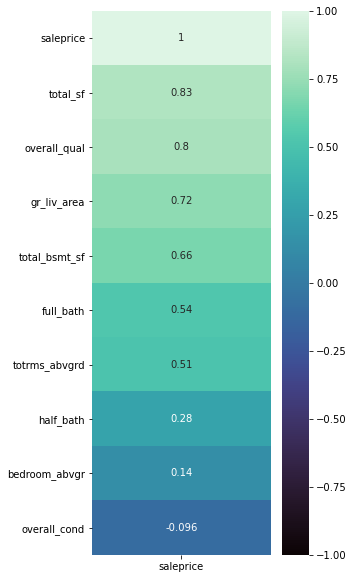

In [61]:
#after the fact check of connections to sale price, seems that total_sf, overall_qual, and full_bath are most important
#gr_liv_area & total_bmsnt sf should have been dropped as they are in total_sf
plt.figure(figsize= (4,10))

sns.heatmap(train_clean[features].corr()[['saleprice']].sort_values('saleprice', ascending = False), 
            annot= True,
           vmax=1,
           vmin=-1,
           cmap='mako');

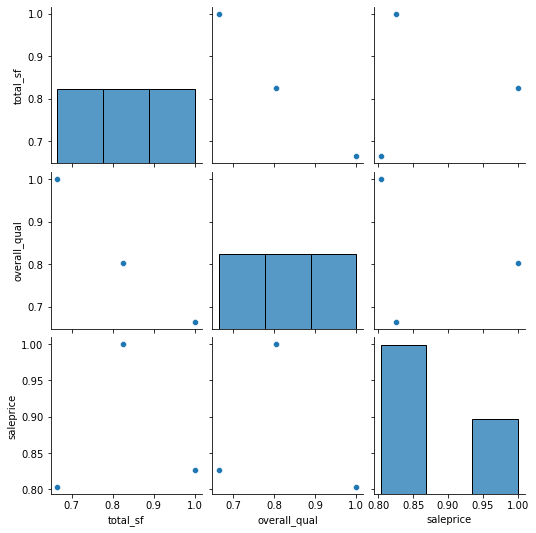

In [62]:
sns.pairplot(train_clean[['total_sf', 'overall_qual', 'saleprice']].corr());

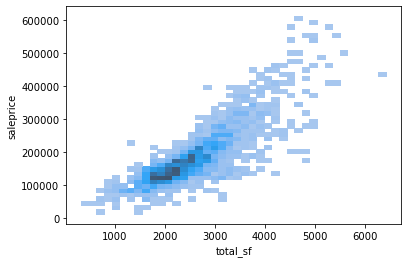

In [66]:
#hist check after the fact of total_sf, seems to be linearly related to price
sns.histplot(data=train_clean, x= train_clean['total_sf'], y=train_clean['saleprice']);

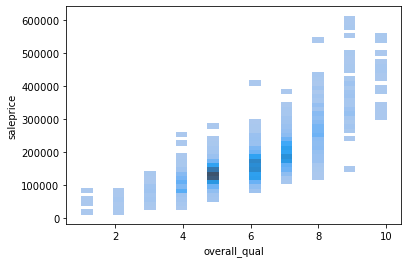

In [68]:
#hist check after the fact, overall quality linear too
sns.histplot(data=train_clean, x= train_clean['overall_qual'], y=train_clean['saleprice']);

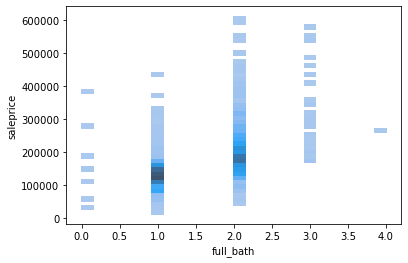

In [70]:
#hist check after the fact, full bath somewhat so
sns.histplot(data=train_clean, x= train_clean['full_bath'], y=train_clean['saleprice']);

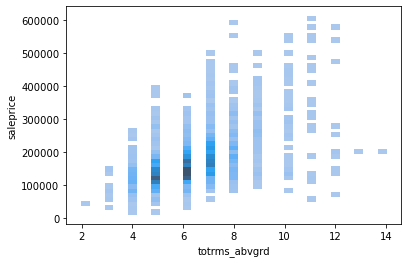

In [71]:
#hist check after the fact, total rms aboveground somewhat linear too
sns.histplot(data=train_clean, x= train_clean['totrms_abvgrd'], y=train_clean['saleprice']);

In [14]:
#quick pipeline for features
def pipeline(df):
    #casting dict for non-int variables
    cast = {
        'Ex' : 5,
        'TA' : 4,
        'Gd' : 3,
        'Fa' : 2,
        'Pr' : 1,
        0  :  0 
    }
    
    features = ['exter_cond', 'exter_qual', 'bsmt_cond', 'bsmt_qual', 'kitchen_qual', 'garage_cond', 'garage_qual', 'overall_cond', 'bedroom_abvgr',
                'overall_qual', 'utilities', 'gr_liv_area', 'total_bsmt_sf', 'full_bath', 'half_bath', 'totrms_abvgrd']
    
    X = df[features]
    
    X.fillna(0, inplace = True)
    
    #utilities
    X['utilities']  = X['utilities'].map({'AllPub' :1, 'NoSewr' : 0, 'NoSeWa' : 0, 'ELO' : 0})
    
    #cast
    
    X['exter_cond'] = X['exter_cond'].map(cast)
    X['exter_qual'] = X['exter_qual'].map(cast)
    X['bsmt_cond']  = X['bsmt_cond'].map(cast)
    X['bsmt_qual']  = X['bsmt_qual'].map(cast)
    X['kitchen_qual']  = X['kitchen_qual'].map(cast)
    X['garage_qual']  = X['garage_qual'].map(cast)
    X['garage_cond']  = X['garage_cond'].map(cast)
    
    #feature interactions
    X['overalls']         = X['overall_qual'] * X['overall_cond']
    
    X['bed_baths_bynd']   = X['full_bath']    * X['totrms_abvgrd']  * X['bedroom_abvgr']
    
    X['exter_overalls']   = X['exter_cond'] * X['exter_qual']
    
    return X

In [15]:
pipeline(train_clean)

,exter_cond,exter_qual,bsmt_cond,bsmt_qual,kitchen_qual,garage_cond,garage_qual,overall_cond,bedroom_abvgr,overall_qual,utilities,gr_liv_area,total_bsmt_sf,full_bath,half_bath,totrms_abvgrd,overalls,bed_baths_bynd,exter_overalls
0,4.0,3,4.0,4.0,3,4.0,4.0,8,3,6,1,1479,725.0,2,1,6,48,36,12.0
1,4.0,3,4.0,3.0,3,4.0,4.0,5,4,7,1,2122,913.0,2,1,8,35,64,12.0
2,3.0,4,4.0,4.0,3,4.0,4.0,7,3,5,1,1057,1057.0,1,0,5,35,15,12.0
3,4.0,4,4.0,3.0,4,4.0,4.0,5,3,5,1,1444,384.0,2,1,7,25,42,16.0
4,4.0,4,3.0,2.0,4,4.0,4.0,8,3,6,1,1445,676.0,2,0,6,48,36,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,4.0,3,4.0,3.0,3,4.0,4.0,5,3,8,1,1728,1884.0,2,0,7,40,42,12.0
2045,4.0,4,4.0,4.0,4,4.0,4.0,5,1,4,1,861,861.0,1,0,4,20,4,16.0
2046,4.0,4,4.0,4.0,4,2.0,2.0,6,3,6,1,1913,896.0,1,1,9,36,27,16.0
2047,4.0,4,4.0,4.0,4,4.0,4.0,5,3,4,1,1200,1200.0,1,0,6,20,18,16.0


In [16]:
X = pipeline(train_clean)

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2048
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   exter_cond      2045 non-null   float64
 1   exter_qual      2047 non-null   int64  
 2   bsmt_cond       1988 non-null   float64
 3   bsmt_qual       1992 non-null   float64
 4   kitchen_qual    2047 non-null   int64  
 5   garage_cond     1926 non-null   float64
 6   garage_qual     1932 non-null   float64
 7   overall_cond    2047 non-null   int64  
 8   bedroom_abvgr   2047 non-null   int64  
 9   overall_qual    2047 non-null   int64  
 10  utilities       2047 non-null   int64  
 11  gr_liv_area     2047 non-null   int64  
 12  total_bsmt_sf   2047 non-null   float64
 13  full_bath       2047 non-null   int64  
 14  half_bath       2047 non-null   int64  
 15  totrms_abvgrd   2047 non-null   int64  
 16  overalls        2047 non-null   int64  
 17  bed_baths_bynd  2047 non-null   i

In [18]:
X.isna().sum()

exter_cond          2
exter_qual          0
bsmt_cond          59
bsmt_qual          55
kitchen_qual        0
garage_cond       121
garage_qual       115
overall_cond        0
bedroom_abvgr       0
overall_qual        0
utilities           0
gr_liv_area         0
total_bsmt_sf       0
full_bath           0
half_bath           0
totrms_abvgrd       0
overalls            0
bed_baths_bynd      0
exter_overalls      2
dtype: int64

In [19]:
X.shape

(2047, 19)

In [20]:
X.dropna()

,exter_cond,exter_qual,bsmt_cond,bsmt_qual,kitchen_qual,garage_cond,garage_qual,overall_cond,bedroom_abvgr,overall_qual,utilities,gr_liv_area,total_bsmt_sf,full_bath,half_bath,totrms_abvgrd,overalls,bed_baths_bynd,exter_overalls
0,4.0,3,4.0,4.0,3,4.0,4.0,8,3,6,1,1479,725.0,2,1,6,48,36,12.0
1,4.0,3,4.0,3.0,3,4.0,4.0,5,4,7,1,2122,913.0,2,1,8,35,64,12.0
2,3.0,4,4.0,4.0,3,4.0,4.0,7,3,5,1,1057,1057.0,1,0,5,35,15,12.0
3,4.0,4,4.0,3.0,4,4.0,4.0,5,3,5,1,1444,384.0,2,1,7,25,42,16.0
4,4.0,4,3.0,2.0,4,4.0,4.0,8,3,6,1,1445,676.0,2,0,6,48,36,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,4.0,3,4.0,3.0,3,4.0,4.0,5,3,8,1,1728,1884.0,2,0,7,40,42,12.0
2045,4.0,4,4.0,4.0,4,4.0,4.0,5,1,4,1,861,861.0,1,0,4,20,4,16.0
2046,4.0,4,4.0,4.0,4,2.0,2.0,6,3,6,1,1913,896.0,1,1,9,36,27,16.0
2047,4.0,4,4.0,4.0,4,4.0,4.0,5,3,4,1,1200,1200.0,1,0,6,20,18,16.0


In [21]:
#rather than drop 120 cells lets just fill with 0
X.fillna(0, inplace=True)

In [22]:
X.isna().sum()

exter_cond        0
exter_qual        0
bsmt_cond         0
bsmt_qual         0
kitchen_qual      0
garage_cond       0
garage_qual       0
overall_cond      0
bedroom_abvgr     0
overall_qual      0
utilities         0
gr_liv_area       0
total_bsmt_sf     0
full_bath         0
half_bath         0
totrms_abvgrd     0
overalls          0
bed_baths_bynd    0
exter_overalls    0
dtype: int64

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [24]:
# X is the X DF I've made from above
y = train_clean['saleprice']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3792)

In [26]:
lr =LinearRegression()

In [27]:
lr.fit(X_train, y_train)

LinearRegression()

In [28]:
#train score
round(lr.score(X_train, y_train), 4)

0.832

In [29]:
#test score
round(lr.score(X_test, y_test), 4)

0.8053

In [30]:
round(cross_val_score(lr, X= X_train, y =y_train, cv=5).mean(), 4)

0.8211

In [31]:
preds = lr.predict(X_test)

In [32]:
#MSE for train
round(mean_squared_error(y_true= y_train, y_pred= lr.predict(X_train)), 2)

1097085750.72

In [33]:
#MSE for test
round(mean_squared_error(y_true= y_test, y_pred= lr.predict(X_test)), 2)

1071240004.75

In [34]:
#RMSE for train
round((mean_squared_error(y_true= y_train, y_pred= lr.predict(X_train)) ** .5), 2)

33122.28

In [35]:
#RMSE for test
round((mean_squared_error(y_true= y_test, y_pred= lr.predict(X_test)) ** .5), 2)

32729.8

In [72]:
#y_intercept for baseline score, somehow negative? That doesn't make sense interpreting as the absence of all of the features leads to a drop of 
#nearly 83,500 dollars in value?
lr.intercept_

-83440.6039942994

In [36]:
list(zip(features, lr.coef_))

[('exter_cond', -29567.84702196968),
 ('exter_qual', -27772.84204304839),
 ('bsmt_cond', -8698.561239746203),
 ('bsmt_qual', 3801.9848289453466),
 ('kitchen_qual', 6493.106388840362),
 ('garage_cond', 543.680954821796),
 ('garage_qual', 3206.9181945843484),
 ('overall_cond', 21374.379339545536),
 ('bedroom_abvgr', -17646.121992180542),
 ('overall_qual', 39556.43858096512),
 ('utilities', -9745.912432719659),
 ('gr_liv_area', 62.54768210088878),
 ('total_bsmt_sf', 55.86612086486275),
 ('full_bath', -1203.1084020705994),
 ('half_bath', 11674.024194006905),
 ('totrms_abvgrd', -1357.547851529952),
 ('total_sf', -3289.7527614294863)]

In [37]:
coefficients = pd.DataFrame(zip(X_test.columns, lr.coef_), columns=['Features', 'Coefficient'])

In [38]:
coefficients

,Features,Coefficient
0,exter_cond,-29567.847022
1,exter_qual,-27772.842043
2,bsmt_cond,-8698.561240
3,bsmt_qual,3801.984829
4,kitchen_qual,6493.106389
5,garage_cond,543.680955
6,garage_qual,3206.918195
7,overall_cond,21374.379340
8,bedroom_abvgr,-17646.121992
9,overall_qual,39556.438581


In [39]:
saleprice = lr.predict(X_test)

In [40]:
len(saleprice)

512

In [41]:
test_df = pd.read_csv('./datasets/test.csv')

In [42]:
test_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [43]:
test_df.rename(str.lower, axis=1, inplace=True)

In [44]:
test_df.columns = test_df.columns.str.replace(' ', '_')

In [45]:
test = pipeline(test_df)

In [46]:
test.fillna(0, inplace=True)

In [47]:
test

,exter_cond,exter_qual,bsmt_cond,bsmt_qual,kitchen_qual,garage_cond,garage_qual,overall_cond,bedroom_abvgr,overall_qual,utilities,gr_liv_area,total_bsmt_sf,full_bath,half_bath,totrms_abvgrd,overalls,bed_baths_bynd,exter_overalls
0,2.0,4,4,2.0,2.0,0.0,0.0,8,4,6,1,1928,1020,2,0,9,48,72,8.0
1,4.0,4,4,3.0,4.0,4.0,4.0,4,6,5,1,1967,1967,2,0,10,20,120,16.0
2,4.0,3,3,3.0,3.0,4.0,4.0,5,3,7,1,1496,654,2,1,7,35,42,12.0
3,4.0,3,4,4.0,4.0,4.0,2.0,6,2,5,1,968,968,1,0,5,30,10,12.0
4,4.0,4,4,3.0,4.0,4.0,4.0,5,3,6,1,1394,1394,1,1,6,30,18,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,4.0,4,4,4.0,4.0,4.0,4.0,6,4,6,1,1877,1084,2,1,8,36,64,16.0
874,3.0,3,4,4.0,3.0,4.0,4.0,7,4,6,1,1988,1104,2,1,9,42,72,9.0
875,4.0,4,4,4.0,4.0,4.0,4.0,5,3,5,1,1211,952,1,0,5,25,15,16.0
876,4.0,4,4,4.0,4.0,4.0,4.0,6,3,4,1,864,864,1,0,5,24,15,16.0


In [48]:
lr.predict(test)

array([ 1.59996846e+05,  2.03181941e+05,  1.85182584e+05,  1.20088064e+05,
        1.91914628e+05,  9.15545685e+04,  1.13541070e+05,  1.66045307e+05,
        2.08902802e+05,  1.73755312e+05,  1.66856600e+05,  1.61050856e+05,
        1.97000826e+05,  3.22373648e+05,  1.91054201e+05,  1.04090081e+05,
        1.68452936e+05,  1.38579111e+05,  2.11190203e+05,  1.96967584e+05,
        1.26894072e+05,  1.03203021e+05,  2.13495861e+05,  1.65320495e+05,
        1.81465100e+05,  1.08128637e+05,  1.23517199e+05,  1.53275070e+05,
        1.31193941e+05,  4.14940998e+02,  9.87482247e+04,  1.07546600e+05,
        2.76681082e+05,  1.41652156e+05,  2.10221684e+05,  1.63278789e+05,
        1.31419106e+05,  5.57472440e+04,  5.75409612e+04,  1.92138845e+05,
        1.44852681e+05,  2.10483952e+05,  1.36583235e+05,  1.57848108e+05,
        2.21939904e+05,  9.22123807e+04,  2.08329306e+05,  1.02481734e+05,
        1.32728039e+05,  1.30792259e+05,  1.32508925e+05,  2.25716545e+05,
        2.49048190e+05,  

In [49]:
test_df['saleprice'] = lr.predict(test)

In [50]:
naive_model_submission =  test_df[['id', 'saleprice']]

In [51]:
naive_model_submission.set_index('id', inplace=True)

In [52]:
naive_model_submission.to_csv('naive_model_submission.csv')